# 官方瑕疵

## 1. batch_size > 1 报错

需要更改 mask_decoder 中 125 行

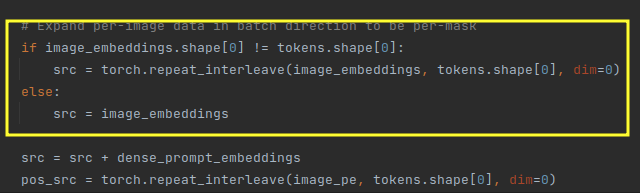

# 数据推理

## 获取训练数据

### 1. dataset.get()

#### 功能

导入原图像和mask，如果需要则随机选择prompt。

#### 数据格式

image: PIL

mask: PIL

point: numpy [N, 2] (x, y)

bbox: numpy [N, 4] (x1, y1, x2, y2)

### 2. dataset.__getitem__()

#### 功能

完成所有预处理操作。在 SAM 中，主要是完成：

1. 导入图像和标签。( PIL -> [H, W, C] )

2. maxResize。这会使得原图像和mask在不改变长宽比例的情况下将最长边resize到符合模型输入的大小，一般是 1024。

3. padding。在上一步的基础上将另一短边padding到模型输入大小。([H, W, C] -> [1024, 1024, C])。

4. normalize 及 toTensor。这不会改变图像大小，只会改变图像属性。([1024, 1024, C] -> [C, 1024, 1024])。

5. mask 会被 clip 到 [0, 1] 之间。

6. prompt 坐标也会随图像大小改变。

#### 数据格式

image: numpy [C, 1024, 1024]

mask: numpy [1, 1024, 1024]

keypoints: numpy [N, 2]

bboxes: numpy [N, 4]

cls_labels: numpy [N]

idx: numpy [1]

### 3. for batch in train_dataloder

#### 功能

遍历 train_dataloader，每次循环随机抽取 batch_size 数据。

#### 数据格式

image: tensor [B, C, 1024, 1024]

mask: tensor [B, 1, 1024, 1024]

keypoints: tensor [B, N, 2]

bboxes: tensor [B, N, 4]

cls_labels: tensor [B, N]

idx: numpy [B, 1]

### 4. prompt 坐标处理

#### 功能

在进行训练之前还需要对 point prompt 进行一些处理（bbox 无需处理）。

#### 数据格式

keypoints: tuple(tensor) ([B, N, 2], [B, N])

### 5. image_encoder

#### 功能

进行图像编码

#### 数据格式

image_embeddings: tensor [B, 256, 64, 64]

### 6. prompt_encoder

#### 功能

进行 prompt 编码。

#### 数据格式

sparse_embeddings: tensor [B, 2, 256]

dense_embeddings: tensor [B, 256, 64, 64]

### 7. mask_decoder

#### 功能

生成低分辨率 mask 和 iou 置信度（这个应该是吧）。这里可以设置 multimask_output 参数来决定是否生成多个 mask。

#### 数据格式

low_res_masks: tensor [B, 1, 256, 256]

iou_predictions: tensor [B, 1]

#### 附加信息

这个时候生成的低分辨率 mask 是二分割结果，官方认为如果结果小于 0，则认为是背景，反之则为前景。如果需要计算 loss，则需要将结果映射到正区间（sigmoid）。

### 8. postprocess_masks

#### 功能

改变 mask 大小，使得和 gt 大小相同进行比较。这里如果必要会依次进行三个操作（custom 中只使用了第一点）：

1. 插值，mask 大小将改变为网络输入大小，一般为 1024。

2. 取值，因为之前存在插值，所以这里从左上角取值，大小将改变为原图像经过 maxResize 后图像的大小。

3. 插值，这一步将完全将 mask 大小改变为原始图像大小。

#### 数据格式

masks: tensor [B, 1, 1024, 1024]